In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from prophet import Prophet
import plotly as plot
from matplotlib import pyplot
from prophet.plot import plot_plotly, plot_components_plotly

import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import requests        
import json           
import pandas as pd    
import numpy as np     

import matplotlib.pyplot as plt 
import datetime as dt 



In [2]:
#Get data

def get_bars(symbol, interval = '1m'):
   root_url = 'https://api.binance.com/api/v1/klines'
   url = root_url + '?symbol=' + symbol + '&interval=' + interval
   data = json.loads(requests.get(url).text)
   df = pd.DataFrame(data)
   df.columns = ['open_time',
                 'o', 'h', 'l', 'c', 'v',
                 'close_time', 'qav', 'num_trades',
                 'taker_base_vol', 'taker_quote_vol', 'ignore']
   df.index = [dt.datetime.fromtimestamp(x/1000.0) for x in df.close_time]
   return df

In [3]:
adabusd = get_bars('ADABUSD')
adabusd = adabusd.reset_index()
adabusd = adabusd.rename(columns={"index":"ds","open_time": "time", "o": "open", "h":"high", "l":"low", "c":"y", "v":"volume"})
df = pd.DataFrame(adabusd, columns = ['ds', 'y'])
df.to_csv(r'data/ada_prophet.csv', mode = 'a', header = True, index=False)

In [4]:
df = pd.read_csv("data/ada_prophet.csv")
df1=df.copy()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


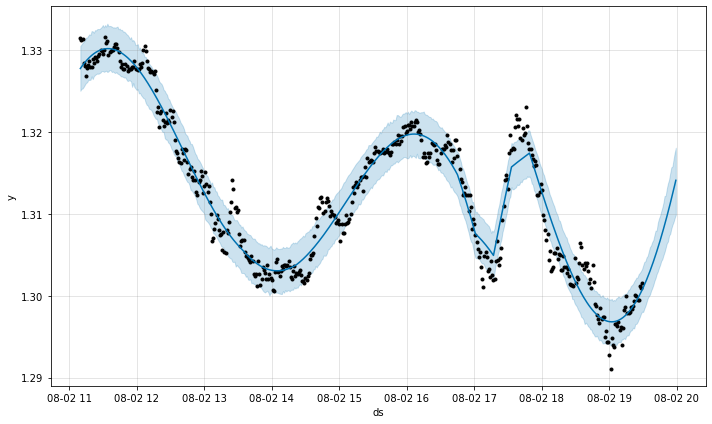

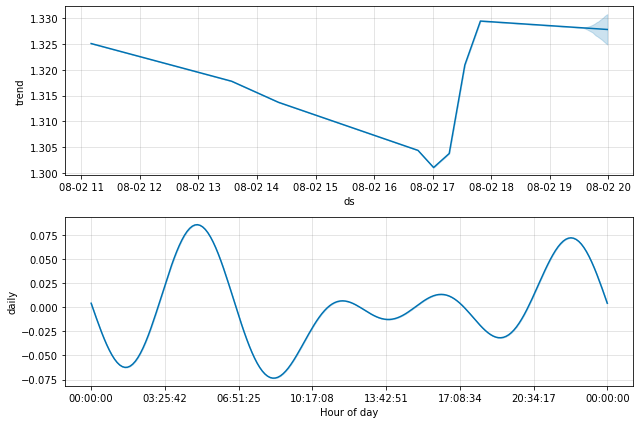

In [5]:
m = Prophet(changepoint_prior_scale=0.01, daily_seasonality=True).fit(df)
future = m.make_future_dataframe(periods=30, freq='1min')
fcst = m.predict(future)
fig = m.plot(fcst)
fig = m.plot_components(fcst)

In [6]:
trace = go.Scatter(
    name = 'Actual price',
    mode = 'markers',
    x = list(fcst['ds']),
    y = list(df['y']),
    marker=dict(
        color='#FFBAD2',
        line=dict(width=1)
    )
)
trace1 = go.Scatter(
    name = 'predict',
    mode = 'lines',
    x = list(fcst['ds']),
    y = list(fcst['yhat']),
    marker=dict(
        color='red',
        line=dict(width=3)
    )
)
upper_band = go.Scatter(
    name = 'upper band',
    mode = 'lines',
    x = list(fcst['ds']),
    y = list(fcst['yhat_upper']),
    line= dict(color='#57b88f'),
    fill = 'tonexty'
)
lower_band = go.Scatter(
    name= 'lower band',
    mode = 'lines',
    x = list(fcst['ds']),
    y = list(fcst['yhat_lower']),
    line= dict(color='#1705ff')
)
tracex = go.Scatter(
    name = 'Actual price',
   mode = 'markers',
   x = list(df1['ds']),
   y = list(df1['y']),
   marker=dict(
      color='black',
      line=dict(width=2)
   )
)
data = [tracex, trace1, lower_band, upper_band, trace]

layout = dict(title='Price Prediction Using Prophet',
             xaxis=dict(title = 'Dates', ticklen=2, zeroline=True))

figure=dict(data=data,layout=layout)
plt.savefig('btc03.png')
py.offline.iplot(figure)

<Figure size 432x288 with 0 Axes>

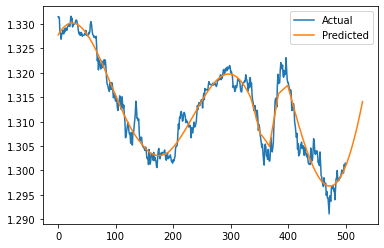

In [7]:
y_true = df['y'].values
y_pred = fcst['yhat'].values

pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()